In [1]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics
using Flight.FlightComponents
using Flight.FlightAircraft.C172FBW
using Flight.FlightAircraft.C172

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

In [2]:
ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

#use default trim condition
design_point = C172.TrimParameters()
test_point = C172.TrimParameters(EAS = 25, flaps = 1)

P_lss_lon = Control.LinearStateSpace(ac, design_point; model = :lon);
P_nss_lon = named_ss(P_lss_lon);

x_labels_lon = keys(P_lss_lon.x0) |> collect
y_labels_lon = keys(P_lss_lon.y0) |> collect
u_labels_lon = keys(P_lss_lon.u0) |> collect
x_labels = deleteat!(x_labels_lon, findfirst(isequal(:h), x_labels_lon))
y_labels = deleteat!(y_labels_lon, findfirst(isequal(:h), y_labels_lon))
u_labels = u_labels_lon
# x_labels = x_labels_lon
# y_labels = y_labels_lon
# u_labels = u_labels_lon

P_lss = submodel(P_lss_lon; x = x_labels, u = u_labels, y = y_labels)
P_nss = named_ss(P_lss);

In [3]:
dampreport(P_nss_lon)
dampreport(P_nss)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+


| -0.000506          |  1            |  0.000506     |  8.05e-05     |  1.98e+03     |


| -0.0192 ±  0.233im |  0.0821       |  0.234        |  0.0373       |  52           |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.0195 ±  0.232im |  0.0838       |  0.232        |  0.037        |  51.4         |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.

We see that removing $h$ as a state eliminates an extremely slow pole, probably related to the effect of altitude on engine output. The remaining poles are virtually unaffected. Also, it significantly improves the condition of the dynamics matrix:

In [4]:
cond(P_nss_lon.A) |> display
cond(P_nss.A) |> display

1.1890917705895528e8

705827.0717951948

But a much more important reason for removing $h$ is that, even if the dynamics matrix is still invertible, the block $H_x F^{-1} G$ in the feedforward gain matrix required for $\theta$ and $EAS$ tracking is not. This is perfectly understandable: we cannot have an arbitrary combination of $\theta$ and $EAS$ and still maintain constant altitude. In other words, keeping $h$ in the state vector produces quasi-static rather than static equilibrium, and therefore we would need partitioning the state to handle it. Note that this issue is only related to the selection of the command variables $\theta$ and $EAS$, not to the system's dynamics. If we picked instead $h$ and $EAS$, we could have true static equilibrium. Thus, for this design we will use the MIMO system without $h$ as our plant baseline. Let's start by designing a full-state feedback regulator for the MIMO system.

## 1. LQR Design

In [5]:
F = P_lss.A
G = P_lss.B
Hx = P_lss.C[(:θ, :EAS), :]
Hu = P_lss.D[(:θ, :EAS), :]
# display(Hx)
# display(Hu)

n_y, n_x = size(Hx) #number of command variables and states

(2, 10)

Assemble the augmented system for LQR design by appending integrator blocks.

In [16]:
Hx_int = Hx
Hu_int = Hu

n_x, n_u = size(G)
n_y, _ = size(Hx) #number of command variables and states
n_int, _ = size(Hx_int)

F_aug = [F zeros(n_x, n_int); Hx_int zeros(n_int, n_int)]
G_aug = [G; Hu_int]
Hx_aug = [Hx zeros(n_y, n_int)]
Hu_aug = Hu

P_aug = ss(F_aug, G_aug, Hx_aug, Hu_aug)
controllability(F_aug, G_aug)


(iscontrollable = true, ranks = [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12], sigma_min = [0.0049300090720645565, 1.2060732252698898, 1.2060732252698902, 1.2060732252698902, 1.2060732252698898, 0.43832990137880945, 0.43362154711136697, 0.43362154711136697, 0.03987170013211874, 0.03987170013211874, 0.002074982409371261, 0.002074982409371261])

Design LQR and check results.

In [7]:
@unpack x0, u0 = P_lss
@unpack v_x, v_z = x0
v_norm = norm([v_x, v_z])

diagQ = ComponentVector(q = 2, θ = 40, v_x = 3/v_norm, v_z = 1/v_norm,
                        α_filt = 0, ω_eng = 0, ele_v = 0, ele_p = 0, thr_v = 0, thr_p = 0,
                        θ_int = 10, EAS_int = 0.002)

diagR = ComponentVector(ele_cmd = 0.1, thr_cmd = 0.2)
# diagQ = ComponentVector(q = 5, θ = 10, v_x = 3/v_norm, v_z = 1/v_norm,
#                         α_filt = 0, ω_eng = 0, ele_v = 0, ele_p = 0, thr_v = 0, thr_p = 0,
#                         θ_int = 100, EAS_int = 0.002)

# diagR = ComponentVector(ele_cmd = 0.2, thr_cmd = 0.2)

Q = ComponentMatrix(diagm(diagQ), Axis(x_labels), Axis(x_labels))
R = ComponentMatrix(diagm(diagR), Axis(x_labels), Axis(x_labels))

#compute gain matrix
C_aug = lqr(P_aug, Q, R)

#extract system state and integrator blocks
C_x = C_aug[:, 1:n_x]
C_ξ = C_aug[:, n_x+1:end]
display(C_ξ)

# quickly construct the closed-loop augmented system to check the resulting
# eigenvalues, we'll do the connections properly later
F_aug_cl = F_aug - G_aug * C_aug
P_aug_cl = ss(F_aug_cl, G_aug, Hx_aug, Hu_aug)

dampreport(P_aug)
dampreport(P_aug_cl)

2×2 Matrix{Float64}:
 9.82201  -0.0265636
 1.32818   0.0982201

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| +0                 |  -1           |  0            |  0            |  -Inf         |
| -0.0195 ±  0.232im |  0.0838       |  0.232        |  0.037        |  51.4         |
| -5.55   ±   6.27im |  0.663        |  8.37         |  1.33         |  0.18         |
| -11.7              |  1            |  11.7         |  1.86         |  0.0856       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -47.2              |  1            |  47.2         |  7.51         |  0.0212       |
|        Pole        |   Damping     |   Fr

Define all gain block and integrator systems:

In [8]:
A = [F G; Hx Hu]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]

C_fbk = C_x
C_fbk_ss = named_ss(ss(C_fbk), u = x_labels, y = [:e_fbk, :t_fbk])

C_fwd = B_22 + C_x * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = [:θ_fwd, :EAS_fwd], y = [:e_fwd, :t_fwd])

C_int = C_ξ
C_int_ss = named_ss(ss(C_int), u = [:θ_int, :EAS_int], y = [:e_int_in, :t_int_in])

int_ss = named_ss(ss(tf(1, [1,0])) .* I(2),
                    x = [:ξ_e, :ξ_t],
                    u = [:e_int_in, :t_int_in],
                    y = [:e_int_out, :t_int_out]);

#in this

nothing

# display(C_fbk_ss)
# display(C_fwd_ss)
# display(C_int_ss)
# display(int_ss)

Define the properly labelled junctions and connections:

In [9]:
θ_sum = sumblock("θ_sum_out = θ_sum_in - θ_dmd_sum_in")
EAS_sum = sumblock("EAS_sum_out = EAS_sum_in - EAS_dmd_sum_in")
elevator_sum = sumblock("e_cmd = e_fwd - e_fbk - e_int_out")
throttle_sum = sumblock("t_cmd = t_fwd - t_fbk - t_int_out")

θ_dmd_splitter = splitter(:θ_dmd, 2)
EAS_dmd_splitter = splitter(:EAS_dmd, 2)

test_connections = vcat(
    Pair.(C_fbk_ss.u, C_fbk_ss.u),
    :e_fwd => :e_fwd,
    :t_fwd => :t_fwd,
    :e_fbk => :e_fbk,
    :t_fbk => :t_fbk,
    :e_int_out => :e_int_out,
    :t_int_out => :t_int_out,
    :θ_dmd1 => :θ_dmd_sum_in,
    :θ_dmd2 => :θ_fwd,
    :EAS_dmd1 => :EAS_dmd_sum_in,
    :EAS_dmd2 => :EAS_fwd,
    :θ_sum_out => :θ_int,
    :EAS_sum_out => :EAS_int,
    :e_int_in => :e_int_in,
    :t_int_in => :t_int_in,
    :θ => :θ_sum_in, #complains about single output to multiple inputs
    :EAS => :EAS_sum_in,
    :e_cmd => :elevator_cmd,
    :t_cmd => :throttle_cmd,
    )


connections = vcat(test_connections)

P_nss_θv = connect([P_nss, int_ss, C_fwd_ss, C_fbk_ss, C_int_ss,
                    θ_sum, EAS_sum, elevator_sum, throttle_sum,
                    θ_dmd_splitter, EAS_dmd_splitter], connections;
                    w1 = [:θ_dmd, :EAS_dmd], z1 = vcat(y_labels, [:e_int_out, :t_int_out]))

dampreport(P_aug_cl)
dampreport(P_nss_θv)


┌ Warning: Connecting single output to multiple inputs Y1=Union{Nothing, Int64}[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 22, 23, 24, 25, 20, 21, 32, 33, 34, 35, 28, 29, 26, 27, 2, 14, 30, 31]
└ @ ControlSystemsBase C:\Users\Miguel\.julia\packages\ControlSystemsBase\TuYDk\src\connections.jl:327


|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -0.179             |  1            |  0.179        |  0.0284       |  5.59         |
| -0.485             |  1            |  0.485        |  0.0772       |  2.06         |
| -1.23   ±  0.291im |  0.973        |  1.27         |  0.202        |  0.811        |
| -7.17              |  1            |  7.17         |  1.14         |  0.139        |
| -11.6              |  1            |  11.6         |  1.85         |  0.086        |
| -18.8   ±   25.1im |  0.6          |  31.4         |  5            |  0.0531       |
| -36.5              |  1            |  36.5         |  5.8          |  0.0274       |
| -20.9   ±   37.1im |  0.492        |  42.6         |  6.77         |  0.0478       |
| -46.3              |  1            |  46.

StepInfo:
Initial value:     0.000
Final value:       1.002
Step size:         1.002
Peak:              1.075
Peak time:         2.021 s
Overshoot:          7.25 %
Undershoot:         0.00 %
Settling time:     5.186 s
Rise time:         0.499 s


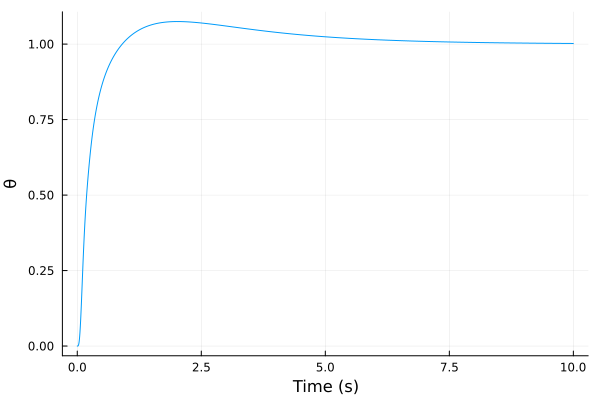

In [10]:
θdmd2θ = P_nss_θv[:θ, :θ_dmd]
θdmd2e = P_nss_θv[:elevator_cmd, :θ_dmd]
step(θdmd2θ, 10) |> stepinfo |> display
step(θdmd2θ, 10) |> plot
# step(θdmd2e, 10) |> plot!

StepInfo:
Initial value:     0.000
Final value:       1.006
Step size:         1.006
Peak:              1.090
Peak time:         3.676 s
Overshoot:          8.38 %
Undershoot:         0.00 %
Settling time:    11.659 s
Rise time:         1.244 s


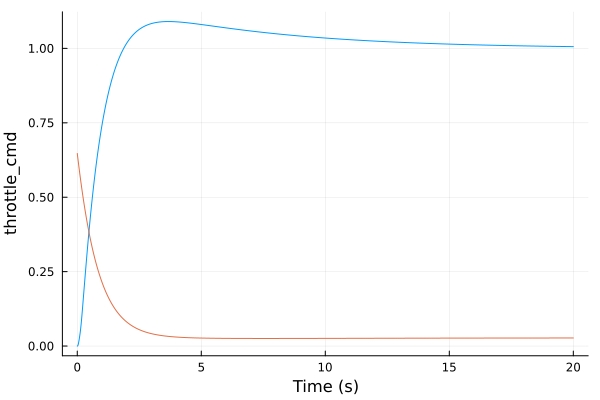

In [11]:
vdmd2v = P_nss_θv[:EAS, :EAS_dmd]
vdmd2t = P_nss_θv[:throttle_cmd, :EAS_dmd]
step(vdmd2v, 20) |> stepinfo |> display
step(vdmd2v, 20) |> plot
step(vdmd2t, 20) |> plot!

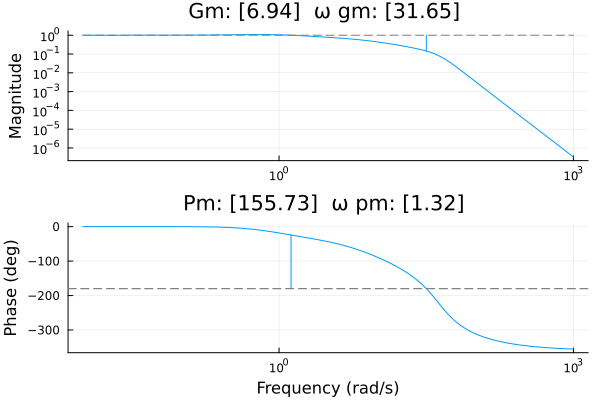

In [12]:
marginplot(θdmd2θ)

## 3. Pitch Rate Tracker

Now, on top of the $\theta$ + $EAS$ tracker we can provide a pitch rate tracker by adding an integrator upstream of the $\theta_{dmd}$ input:

In [13]:
q_int = tf(1, [1, 0])
q_ff = named_ss(q_int |> ss, u = :q_dmd, y = :θ_dmd)
P_nss_qv = connect([q_ff, P_nss_θv], [:θ_dmd => :θ_dmd]; w1 = [:q_dmd, :EAS_dmd], z1 = P_nss_θv.y)
qdmd2q = P_nss_qv[:q, :q_dmd];

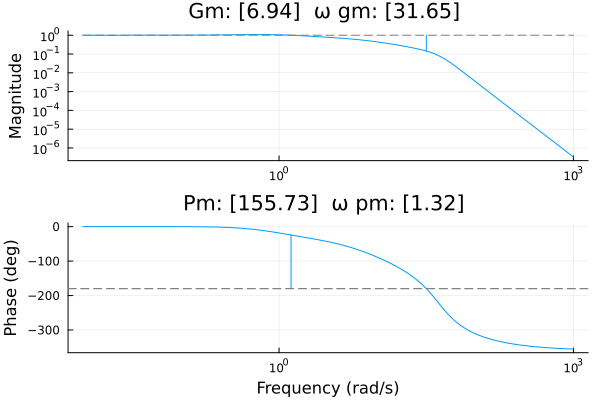

In [14]:
marginplot(qdmd2q)

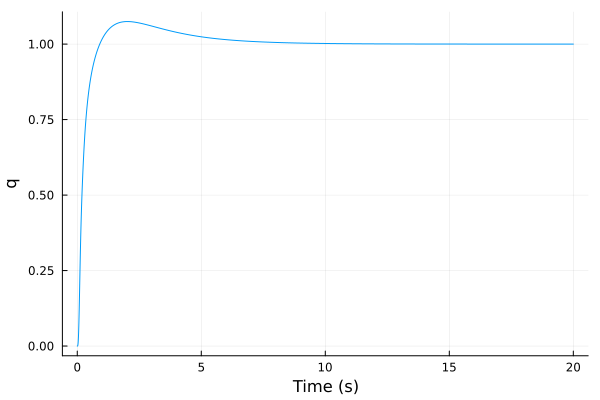

In [15]:
step(qdmd2q, 20) |> plot

In the actual implementation, $\dot{\theta}$ should not be computed directly as $\dot{\theta} = q_{dmd}$ but through the kinematic relation:
$$ q(\dot{\theta}, r, \phi) = \dfrac{1}{\cos \phi}(\dot{\theta} + r \tan \phi) $$
$$ \dot{\theta}_{dmd} = q_{dmd} \cos \phi - r \tan \phi$$